# Estimation of correlation between centroid offset and the $\Sigma$ values

**Author(s):** Muhammad Jobair Hasan, Anowar J. Shajib

## Uncertainty propagation and the pearson correlation coeffient ($r$)

We assume that the centroids (`"center_x_light"`, `"center_x_mass"`, `"center_y_light"`, `"center_y_mass"`) conform to Gaussian distributions of means equaling the corresponding medians and the standard deviations equaling the corresponding averages (of the upper and the lower) $1\sigma$ uncertainties. These uncertainties propagate (in our calculations using the Euclidean distance formula) to the values of light and mass centeroid offsets. We then use normal distributions having the calculated (uncertainties propagated) means and uncertainties (standard deviations) to sample from and calculate the pearson correlation cofficient ($r$) between the centeroid offsets and the $\Sigma$ values. By sampling multiple times and calculating the $r$ we get a population of $r$ values and thus calculate the mean, $1\sigma$ upper and $1\sigma$ lower uncertainties.

The four $\Sigma$ values we consider are:
- $\Sigma_{10}$
- $\Sigma_{10, \rm flux\ selected}$
- $\Sigma_{20}$
- $\Sigma_{20, \rm flux\ selected}$

## Relevant formulae


For the case of $f = aA + bB$, where A and B are two random variables and a, b are constants, we have $$\sigma_{f} = \sqrt{a^{2}\sigma_{A}^2 + b^{2}\sigma_{B}^2 - 2ab\sigma_{AB}}$$
In the case of independent A, B ($\sigma_{AB}=0$) and $a=b=1$ we have $$\sigma_{f} = \sqrt{\sigma_{A}^2 + \sigma_{B}^2}$$
We also have for independent A, B ($\sigma_{AB}=0$) and $f = \sqrt{A^{2}+B^{2}}$,
$$\sigma_{f} \approx \sqrt{\left(\frac{A}{f}\right)^{2}\sigma_{A}^{2} + \left(\frac{B}{f}\right)^{2}\sigma_{B}^{2}}$$

## Import the necessary libraries

In [61]:
import yaml
import numpy as np
from statistics import mean
from numpy.random import normal
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

## List of the model names

In [62]:
lens_names = [
    "DESIJ1018-0121",
    "DESIJ1205+4110",
    "DESIJ1709+3154",
]

## Uncertainty propagation

In [63]:
num_lens = len(lens_names)

# list for storing the Sigmas
Sigma_10_dset = []
Sigma_10fs_dset = []
Sigma_20_dset = []
Sigma_20fs_dset = []

data_points = []  # list dictionaries with the parameter values
center_diffs = []  # mean offsets between the light and mass centers
sigma_center_diffs = []  # uncertainty propagated standard deviation of the center offsets


for i in range(num_lens):
    lens_name = lens_names[i]

    output_path = f"../lens_systems/{lens_name}/{lens_name}_point_estimates.yml"

    try:
        with open(output_path, "r") as f:
            data = yaml.full_load(f)

    except AttributeError:
        print(f"Failed to load {lens_name}")
        continue
    

    output = {
    'center_x_light': data.get('center_x_light'),
    'center_x_mass': data.get('center_x_mass'),
    'center_y_light': data.get('center_y_light'),
    'center_y_mass': data.get('center_y_mass'),
    'Sigma_10': data.get('Sigma_10'),
    'Sigma_10_flux_selected': data.get('Sigma_10_flux_selected'),
    'Sigma_20': data.get('Sigma_20'),
    'Sigma_20_flux_selected': data.get('Sigma_20_flux_selected')
    }

    data_points.append(output)

    Sigma_10_dset.append(data.get('Sigma_10'))
    Sigma_10fs_dset.append(data.get('Sigma_10_flux_selected'))
    Sigma_20_dset.append(data.get('Sigma_20'))
    Sigma_20fs_dset.append(data.get('Sigma_20_flux_selected'))


    x_diff = abs(data_points[i]['center_x_light'][0] - data_points[i]['center_x_mass'][0])
    y_diff = abs(data_points[i]['center_y_light'][0] - data_points[i]['center_y_mass'][0])
    center_diff = (x_diff**2 + y_diff**2)**0.5
    center_diffs.append(center_diff)

    sigma_x_light = mean([data_points[i]['center_x_light'][1], data_points[i]['center_x_light'][2]])
    sigma_x_mass = mean([data_points[i]['center_x_mass'][1], data_points[i]['center_x_mass'][2]])
    sigma_y_light = mean([data_points[i]['center_y_light'][1], data_points[i]['center_y_light'][2]])
    sigma_y_mass = mean([data_points[i]['center_y_mass'][1], data_points[i]['center_y_mass'][2]])

    sigma_x_diff = (sigma_x_light**2 + sigma_x_mass**2)**0.5
    sigma_y_diff = (sigma_y_light**2 + sigma_y_mass**2)**0.5

    sigma_center_diff = (((x_diff / center_diff)**2)*sigma_x_diff**2 + ((y_diff / center_diff)**2)*sigma_y_diff**2)**0.5
    sigma_center_diffs.append(sigma_center_diff)

## Sampling and pearson correlation coefficient ($r$) calculation

### Function definitions

In [64]:
# function for sampling and calculating the pearson correlation coefficients 

def sample_and_calc_r(param2, size):
     """
     Sample and calculate pearson-r between centroid offset and the param2, and return
     a list of the form [r_median, r_upper, r_lower].

     :param param2: a string; keyword for the parameter between which and 
      the centroid offset, pearson-r has to be calculated.
     :param size: population size of the pearson-r samples.
     :return: list; [r_median, r_upper, r_lower]
     """

     from numpy.random import normal
     from scipy.stats import pearsonr
     
     
     samples_delta_center = []
     p2 = []
     samples_r = []
    
     for i in range(size):
        for j in range(num_lens):
            samples_delta_center.append(normal(center_diffs[j], sigma_center_diffs[j]))
            p2.append(data_points[j][param2])
        
        samples_r.append(pearsonr(samples_delta_center, p2))
    
     samples_r_arr = np.array([x.statistic for x in samples_r])
     r_median = np.median(samples_r_arr).item()
     r_lower = np.percentile(samples_r_arr, 16.0).item()
     r_upper = np.percentile(samples_r_arr, 84.0).item()

     return [r_median, r_upper, r_lower]

### pearson-$r$ calculation

In [65]:
size = 100  # population size

In [66]:
# calculate the pearson-r for the four cases of Sigma

r_Sigma_10 = sample_and_calc_r("Sigma_10", size)
r_Sigma_10fs = sample_and_calc_r("Sigma_10_flux_selected", size)
r_Sigma_20 = sample_and_calc_r("Sigma_20", size)
r_Sigma_20fs = sample_and_calc_r("Sigma_20_flux_selected", size)

print(r_Sigma_10)
print(r_Sigma_10fs)
print(r_Sigma_20)
print(r_Sigma_20fs)

[0.7875625145564245, 0.7888133536307496, 0.7824532003272471]
[0.7062045823515599, 0.7105197327953002, 0.7031112271147414]
[0.9803645651054438, 0.9818230248374155, 0.9794246661419328]
[0.4476781142992807, 0.4516226672843777, 0.4460247385107786]


## Scatter plot overlaid with error bar (centroid offset vs. $\Sigma$)

In [67]:
# Set the matplotlib typography

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = 'dejavusans'
plt.rcParams["font.size"] = 12

In [70]:
# Function for scatter ploting with error bars

def scatter_errbar_plot(dset, param, r, ax0):
    """
    Create scatter plot with error bars with respect to the centroid offset.
    """
    # ax0.scatter(dset, center_diffs, c="r", s=100, alpha=0.3)
    ax0.errorbar(dset, center_diffs, 
             yerr=sigma_center_diffs, 
             fmt='o', color='r', alpha=0.3)
    
    match param:
        case 'S_10':
            ax0.set_xlabel(r'$\Sigma_{10}$')
        case 'S_10fs':
            ax0.set_xlabel(r'$\Sigma_{10, \rm flux\ selected}$')
        case 'S_20':
            ax0.set_xlabel(r'$\Sigma_{20}$')
        case 'S_20fs':
            ax0.set_xlabel(r'$\Sigma_{20, \rm flux\ selected}$')
    
    ax0.set_ylabel(r'centroid offset')

    ax0.tick_params(direction='in')
    ax0.text(0.8, 0.15, f'$r$={r[0]:.2f}$\pm${(r[1]-r[2])*.5:.2f}', 
         horizontalalignment='center', verticalalignment='center', 
         transform=ax0.transAxes, fontsize=16, color='r')

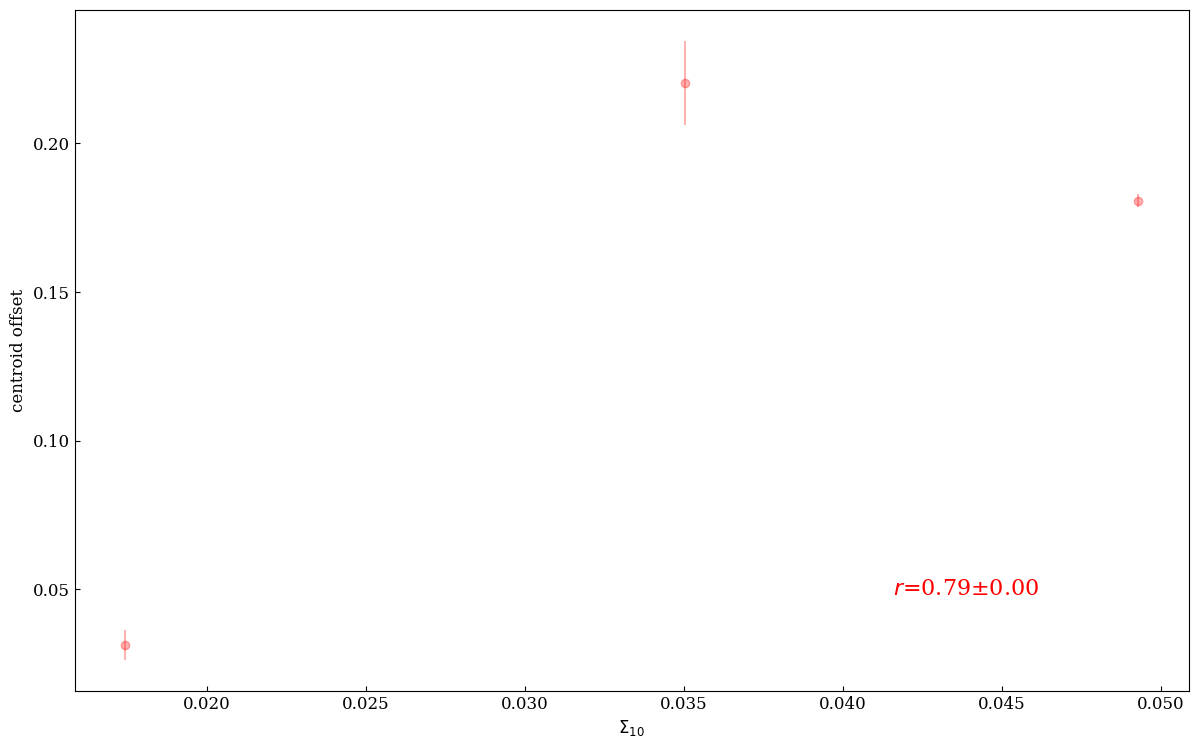

In [71]:
# plot for the case of centroid offset vs. Sigma_10

fig, ax = plt.subplots(1, 1, figsize=(12, 7.5))
fig.tight_layout()


scatter_errbar_plot(Sigma_10_dset, 'S_10', r_Sigma_10, ax)

plt.show()
fig.savefig("../paper/figures/centroid_offset_vs_Sigma_10.pdf", bbox_inches="tight")


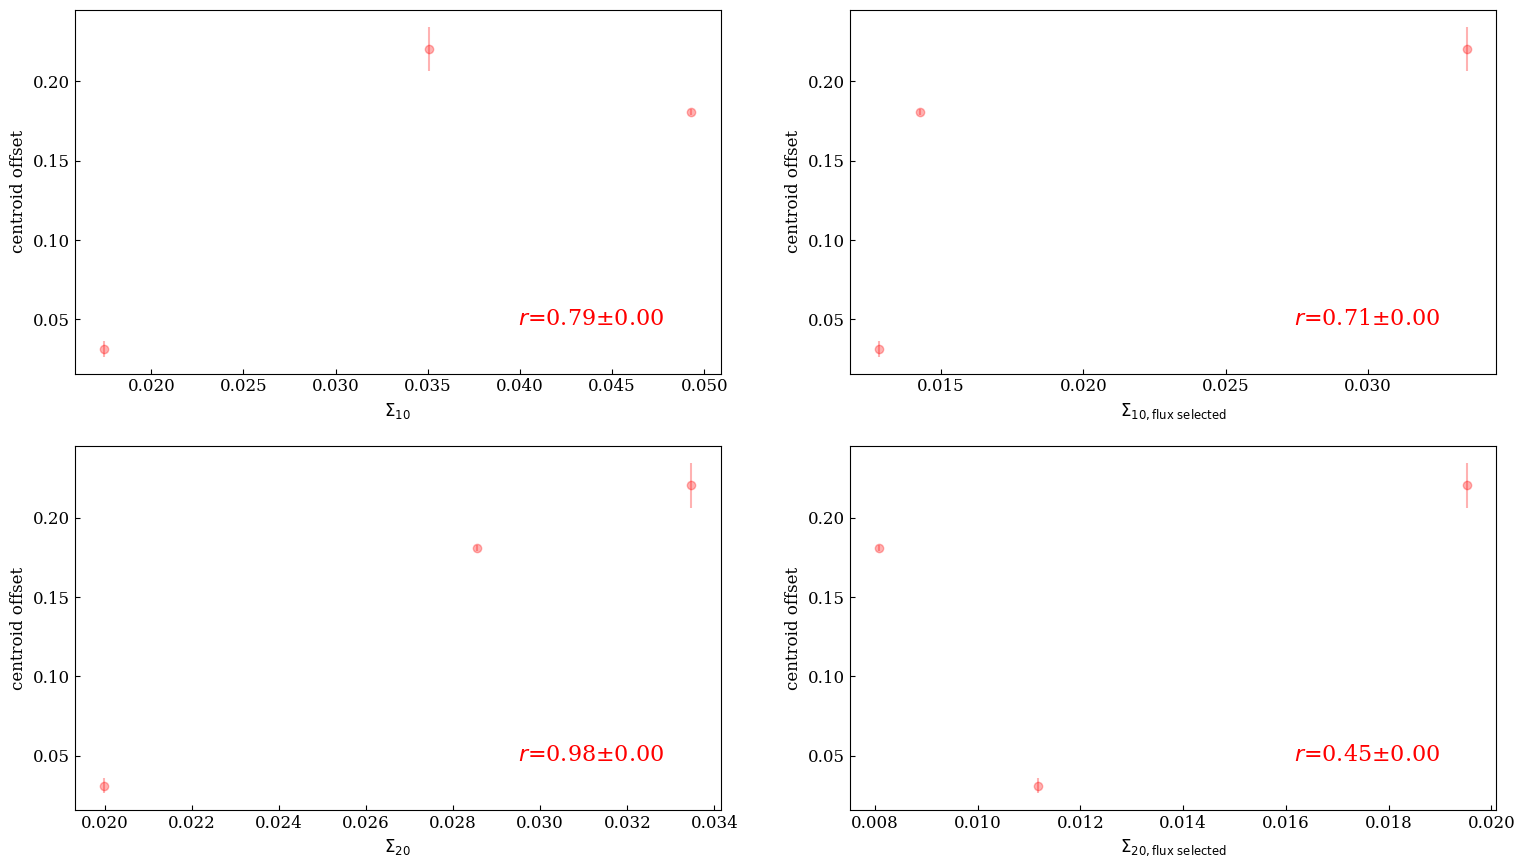

In [72]:

# plot for all the four cases of centroid offset vs. Sigmas

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(17.77, 10))
fig.tight_layout()
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.2)


scatter_errbar_plot(Sigma_10_dset, 'S_10', r_Sigma_10, ax1)
scatter_errbar_plot(Sigma_10fs_dset, 'S_10fs', r_Sigma_10fs, ax2)
scatter_errbar_plot(Sigma_20_dset, 'S_20', r_Sigma_20, ax3)
scatter_errbar_plot(Sigma_20fs_dset, 'S_20fs', r_Sigma_20fs, ax4)

plt.show()
fig.savefig("../paper/figures/centroid_offset_vs_Sigma_all.pdf", bbox_inches="tight")